<a href="https://colab.research.google.com/github/shiv6146/neural_nets/blob/main/makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bigram Language model - Character Level (probabilistic approach based on bigram frequencies)

Here we are trying to build a bigram language model that predicts the next character based on bigram frequencies in the training set. Our training set is a list of indian names from [here](https://www.kaggle.com/datasets/ananysharma/indian-names-dataset?resource=download)

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/shiv6146/neural_nets/main/names.txt

In [8]:
f = [name.rstrip() for name in open('names.txt').readlines()]
words = []
for w in f:
  if w.isalpha():
    words.append(w)
chars = sorted(set(''.join(words)))
print(chars)
print(len(words))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
6467


In [9]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [10]:
import torch
N = torch.zeros((27, 27), dtype=torch.int32)

In [11]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

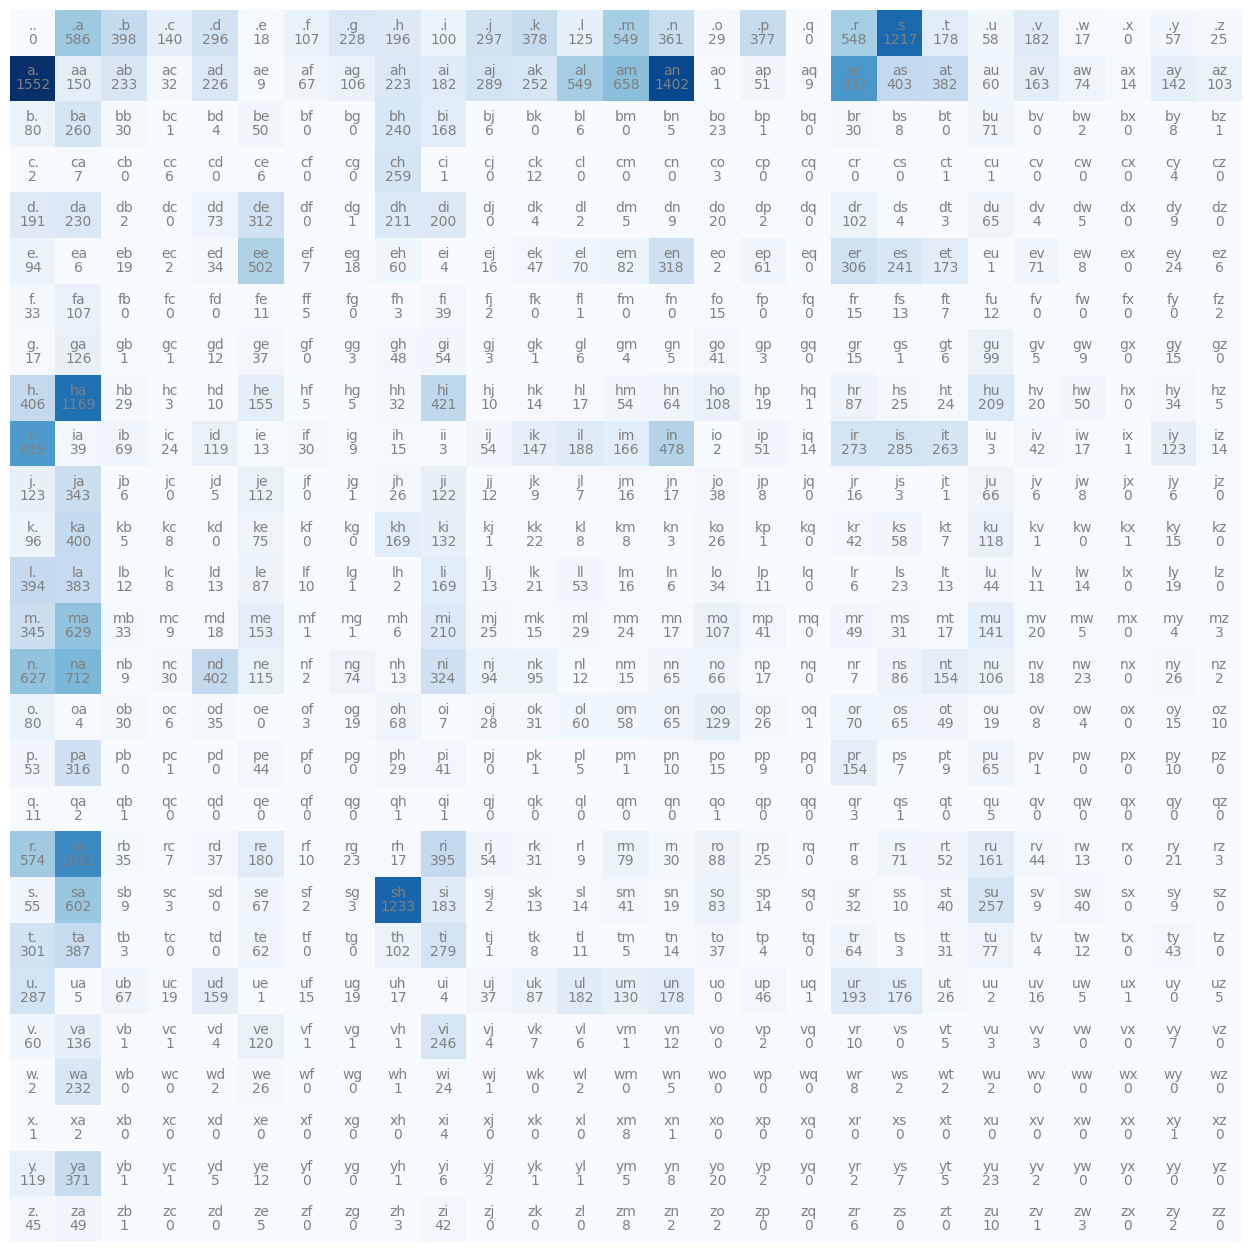

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')

In [15]:
N[0]

tensor([   0,  586,  398,  140,  296,   18,  107,  228,  196,  100,  297,  378,
         125,  549,  361,   29,  377,    0,  548, 1217,  178,   58,  182,   17,
           0,   57,   25], dtype=torch.int32)

In [19]:
# convert frequencies to probability distribution
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0906, 0.0615, 0.0216, 0.0458, 0.0028, 0.0165, 0.0353, 0.0303,
        0.0155, 0.0459, 0.0585, 0.0193, 0.0849, 0.0558, 0.0045, 0.0583, 0.0000,
        0.0847, 0.1882, 0.0275, 0.0090, 0.0281, 0.0026, 0.0000, 0.0088, 0.0039])

In [51]:
# create a probability vector from N vector which contains the frequencies
# of bigrams. To create this probability vector we need to convert to float
# and then sum up each row and normalize to get a column vector (27, 1)
# adding 1 to N is to prevent loss pointing to inf when some bigram probs=0
# this is called model smoothing
P = (N+1).float()
# this operation follows broadcasting semantics in pytorch
# 27, 27
# 27, 1
P /= P.sum(1, keepdim=True)

In [52]:
# random sample from probability distribution using pre-seeded torch
# generator to keep the results deterministic
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junjdedil.
akar.
p.
shay.
a.
na.
kuhinttohirasatha.
sulanaauranileviaj.
dedainrwam.
r.
shaninay.
arta.
farmumesafod.
muj.
prinsumahajani.
cora.
yar.
panar.
sabi.
nerimikim.


In [54]:
# log(p1*p2*p3) = log(p1) + log(p2) + log(p3)
# likelihood of bigram is the prod of probabilities but its a too small num
# hence log prob is used so for higher prob the logprob is close to 0 and
# for lower prob the logprob is close to -ve inf but this is inverse semantics
# to be used for loss fn since we intend to min loss in our training hence
# use negative log likelihood
log_likelihood = 0.0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
normalized_nll = nll / n
print(f'{normalized_nll=}')

log_likelihood=tensor(-112152.5938)
nll=tensor(112152.5938)
normalized_nll=tensor(2.3579)


# Bigram Language Model - Character Level (Neural Networks approach)

We are going to tune the weights of the neural network which takes in a single character as input and output the next character in the sequence based on the likelihood, using the nll loss fn and gradient based optimization

In [55]:
# create training set of all bigrams (x, y) for neural net approach
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. a
a a
a b
b i
i d
d .


In [57]:
xs

tensor([0, 1, 1, 2, 9, 4])

In [58]:
ys

tensor([1, 1, 2, 9, 4, 0])

In [63]:
# one hot encoding to feed inputs to neural net since indices need to be
# converted to vector of floats
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [64]:
xenc.shape

torch.Size([6, 27])

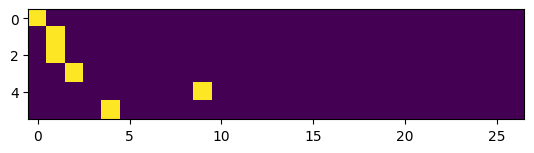

In [65]:
plt.imshow(xenc)

In [82]:
# 27 neurons => w.x + b
# randomly init 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)
# matrix multiply op of pytorch is equivalent to taking dot products of weights
# and inputs in parallel
# (6, 27) @ (27, 27) => (6, 27)
xenc @ W

tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046, -0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,
          1.5618, -1.6261,  0.6772, -0.8404,  0.9849, -0.1484, -1.4795,  0.4483,
         -0.0707,  2.4968,  2.4448],
        [-0.6701, -1.2199,  0.3031, -1.0725,  0.7276,  0.0511,  1.3095, -0.8022,
         -0.8504, -1.8068,  1.2523, -1.2256,  1.2165, -0.9648, -0.2321, -0.3476,
          0.3324, -1.3263,  1.1224,  0.5964,  0.4585,  0.0540, -1.7400,  0.1156,
          0.8032,  0.5411, -1.1646],
        [-0.6701, -1.2199,  0.3031, -1.0725,  0.7276,  0.0511,  1.3095, -0.8022,
         -0.8504, -1.8068,  1.2523, -1.2256,  1.2165, -0.9648, -0.2321, -0.3476,
          0.3324, -1.3263,  1.1224,  0.5964,  0.4585,  0.0540, -1.7400,  0.1156,
          0.8032,  0.5411, -1.1646],
        [ 0.1476, -1.0006,  0.3801,  0.4733, -0.9103, -0.7830,  0.1351, -0.2116,
         -1.0406, -1.5367,  0.9374, -0.8830,  1.7457,  2.1346, -0.8561,  0.5408

In [83]:
(xenc @ W)[3, 13]

tensor(2.1346)

In [84]:
xenc[3]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [85]:
W[:, 13]

tensor([-4.3297e-01, -9.6478e-01,  2.1346e+00, -7.2759e-01, -1.3753e-01,
        -1.3132e-03, -3.1566e-01,  1.1199e+00, -4.7701e-01, -1.5065e+00,
         1.2108e+00, -4.0636e-01,  1.9110e-01,  3.7882e-02,  1.3431e+00,
         2.4311e-01, -1.5364e-01, -1.1583e+00,  1.1614e+00,  4.2016e-01,
         2.7359e-01,  3.6583e-01,  1.7128e+00,  1.3769e+00, -8.9778e-01,
        -9.5177e-01,  1.4723e-01])

In [86]:
# w.x + b
(xenc[3] * W[:, 13]).sum()

tensor(2.1346)

In [90]:
# log counts (-ve and +ve) => exponentiation => counts (strictly +ve) (-ve log counts => less than 1,
# +ve log counts => greater than 1)
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # neural net prediction: log_counts (-ve and +ve)
# softmax => the below 2 ops together
counts = logits.exp() # counts: equivalent to N (strictly +ve)
probs = counts / counts.sum(1, keepdim=True) # probs for next character
probs

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0150, 0.0086, 0.0396, 0.0100, 0.0606, 0.0308, 0.1084, 0.0131, 0.0125,
         0.0048, 0.1024, 0.0086, 0.0988, 0.0112, 0.0232, 0.0207, 0.0408, 0.0078,
         0.0899, 0.0531, 0.0463, 0.0309, 0.0051, 0.0329, 0.0654, 0.0503, 0.0091],
        [0.0150, 0.0086, 0.0396, 0.0100, 0.0606, 0.0308, 0.1084, 0.0131, 0.0125,
         0.0048, 0.1024, 0.0086, 0.0988, 0.0112, 0.0232, 0.0207, 0.0408, 0.0078,
         0.0899, 0.0531, 0.0463, 0.0309, 0.0051, 0.0329, 0.0654, 0.0503, 0.0091],
        [0.0249, 0.0079, 0.0314, 0.0344, 0.0086, 0.0098, 0.0246, 0.0174, 0.0076,
         0.0046, 0.0548, 0.0089, 0.1230, 0.1814, 0.0091, 0.0369, 0.0398, 0.0977,
         0.0075, 0.0110, 0.0104, 0.1236, 0.0256, 0.0579, 0.0115, 0.0232, 0.0067],
        [0.0227, 0.1059,

In [91]:
nlls = torch.zeros(6)
for i in range(6):
  # i-th bigram
  x = xs[i].item() # input char idx
  y = ys[i].item() # label char idx
  print('----------')
  print(f'bigram ex {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print(f'input to neural net: {x}')
  print(f'output probs from the neural net: {probs[i]}')
  print(f'label (actual nxt char): {y}')
  p = probs[i, y]
  print(f'prob assigned by the neural net to the correct char: {p.item()}')
  logp = torch.log(p)
  print(f'log likelihood: {logp.item()}')
  nll = -logp
  print(f'negative log likelihood: {nll.item()}')
  nlls[i] = nll
print('============')
print(f'avg negative log likelihood, i.e. loss = {nlls.mean().item()}')

----------
bigram ex 1: .a (indexes 0,1)
input to neural net: 0
output probs from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual nxt char): 1
prob assigned by the neural net to the correct char: 0.009982486255466938
log likelihood: -4.6069231033325195
negative log likelihood: 4.6069231033325195
----------
bigram ex 2: aa (indexes 1,1)
input to neural net: 1
output probs from the neural net: tensor([0.0150, 0.0086, 0.0396, 0.0100, 0.0606, 0.0308, 0.1084, 0.0131, 0.0125,
        0.0048, 0.1024, 0.0086, 0.0988, 0.0112, 0.0232, 0.0207, 0.0408, 0.0078,
        0.0899, 0.0531, 0.0463, 0.0309, 0.0051, 0.0329, 0.0654, 0.0503, 0.0091])
label (actual nxt char): 1
prob assigned by the neural net to the correct char: 0.008642823435366154
log likelihood: -4.751026153564453
negat

In [ ]:
# ---------------- !!! OPTIMIZATION !!! -----------------

In [92]:
xs

tensor([0, 1, 1, 2, 9, 4])

In [93]:
ys

tensor([1, 1, 2, 9, 4, 0])

In [109]:
# randomly init 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [110]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to neural net: one-hot encoding
logits = xenc @ W # predict log counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdim=True) # probs for next character

In [111]:
# pluck out probs for nxt char (ys) for input xs (since there are 6 train ex / bigrams for first word)
probs[0, 1], probs[1, 1], probs[2, 2], probs[3, 9], probs[4, 4], probs[5, 0]

(tensor(0.0100, grad_fn=<SelectBackward0>),
 tensor(0.0086, grad_fn=<SelectBackward0>),
 tensor(0.0396, grad_fn=<SelectBackward0>),
 tensor(0.0046, grad_fn=<SelectBackward0>),
 tensor(0.0728, grad_fn=<SelectBackward0>),
 tensor(0.0077, grad_fn=<SelectBackward0>))

In [112]:
# the above can be written like this in pytorch
probs[torch.arange(6), ys]

tensor([0.0100, 0.0086, 0.0396, 0.0046, 0.0728, 0.0077],
       grad_fn=<IndexBackward0>)

In [113]:
loss = -probs[torch.arange(6), ys].log().mean()
loss

tensor(4.2412, grad_fn=<NegBackward0>)

In [114]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to neural net: one-hot encoding
logits = xenc @ W # predict log counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdim=True) # probs for next character
loss = -probs[torch.arange(6), ys].log().mean()

In [115]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [119]:
# update the weights (to the opp direction of gradient)
W.data += -0.1 * W.grad

In [ ]:
# ---------- !!! Optimization !!! ---------- end-to-end

In [127]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f'num of ex: {num}')

# init the neural net
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

num of ex: 47565


In [128]:
# gradient descent
for k in range(100):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to neural net: one-hot encoding
  logits = xenc @ W # predict log_counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdim=True) # probs for nxt char
  # in addition to loss, regularization loss is something which we add to get uniform probs
  # by trying to push W close to 0
  loss = -probs[torch.arange(num), ys].log().mean() + (0.01*(W**2).mean())
  print(loss.item())

  # backward pass
  W.grad = None # set gradient to zero before backprop
  loss.backward()

  # update weights
  W.data += -50 * W.grad

3.775243043899536
3.3188209533691406
3.064979314804077
2.9260001182556152
2.8387374877929688
2.7735631465911865
2.7216110229492188
2.6789791584014893
2.6433944702148438
2.613409996032715
2.5880355834960938
2.566528558731079
2.548276424407959
2.532743453979492
2.5194551944732666
2.508005380630493
2.4980573654174805
2.4893457889556885
2.481660842895508
2.474839687347412
2.4687516689300537
2.463292360305786
2.4583747386932373
2.453927755355835
2.4498913288116455
2.446214199066162
2.4428539276123047
2.4397735595703125
2.436940908432007
2.4343299865722656
2.4319164752960205
2.429680347442627
2.4276034832000732
2.425670623779297
2.423867702484131
2.422183036804199
2.4206058979034424
2.4191267490386963
2.4177372455596924
2.416429281234741
2.4151968955993652
2.414033889770508
2.4129343032836914
2.411893367767334
2.41090726852417
2.4099717140197754
2.4090828895568848
2.4082376956939697
2.407432794570923
2.406665563583374
2.4059340953826904
2.405235528945923
2.404568672180176
2.4039299488067627


In [130]:
# predict / sample from the model
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
  out = []
  ix = 0
  while True:
    # ----------
    # inference: probabilistic approach
    # p = P[ix]
    # ----------
    # inference: neural net approach
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log_counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdim=True) # probs for nxt char
    # ----------
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junjdedil.
akar.
p.
sfay.
a.


# Trigram Language Model - Character Level (Multi Layer Perceptron approach)

Here we are moving one step further in building the language model, now we are taking in 3 chars as input context to predict the most likely 4th char as output. We will do this by building a Multi Layer Perceptron network

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/shiv6146/neural_nets/main/names.txt

In [2]:
f = [name.rstrip() for name in open('names.txt').readlines()]
words = []
for w in f:
  if w.isalpha():
    words.append(w)
chars = sorted(set(''.join(words)))
print(chars)
print(len(words))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
6467


In [64]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [26]:
# build the dataset
block_size = 3 # context length: how many char do we take to predict the nxt one?
X, Y = [], []
for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

aabid
... ---> a
..a ---> a
.aa ---> b
aab ---> i
abi ---> d
bid ---> .
aabida
... ---> a
..a ---> a
.aa ---> b
aab ---> i
abi ---> d
bid ---> a
ida ---> .
aachal
... ---> a
..a ---> a
.aa ---> c
aac ---> h
ach ---> a
cha ---> l
hal ---> .
aadesh
... ---> a
..a ---> a
.aa ---> d
aad ---> e
ade ---> s
des ---> h
esh ---> .
aadil
... ---> a
..a ---> a
.aa ---> d
aad ---> i
adi ---> l
dil ---> .


In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([33, 3]), torch.int64, torch.Size([33]), torch.int64)

In [6]:
# building lookup table C => embedding space of 27 possible chars into 2D space
C = torch.randn((27, 2))

In [7]:
# pytorch multi-dimensional indexing allows us to fetch for all X
# the coressponding embedding from lookup table C
emb = C[X]
emb.shape

torch.Size([33, 3, 2])

In [8]:
# init weigts (first layer)
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
# to achieve emb @ W1 + b1 => we need to convert emb.shape => (33, 6)
# hidden layer with tanh activation
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([33, 100])

In [9]:
# final layer (output)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [10]:
# hidden layer out is feeded into final layer (output)
logits = h @ W2 + b2

In [11]:
logits.shape

torch.Size([33, 27])

In [16]:
# log_counts => counts => prob distribution
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(33), Y].log().mean()
# the above 3 lines can be replaced by the following line to calc the loss
loss = F.cross_entropy(logits, Y)
loss

tensor(20.6478)

In [17]:
# ---------- !!! Optimization !!! ----------

In [183]:
# build the dataset
def build_dataset(words):
  block_size = 3 # context length: how many char do we take to predict the nxt one?
  X, Y = [], []
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([38028, 3]) torch.Size([38028])
torch.Size([4789, 3]) torch.Size([4789])
torch.Size([4748, 3]) torch.Size([4748])


In [190]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [C, W1, b1, W2, b2]

In [191]:
sum(p.nelement() for p in params) # num of params in total

11897

In [192]:
for p in params:
  p.requires_grad = True

In [193]:
# finding a learning rate first involves identifying max lr where loss explodes
# and the min lr where loss barely reduces, then get all intermediate nums btw the range
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [194]:
lri = []
lossi = []
stepi = []

In [201]:
for i in range(50000):

  # NOTE: training on mini batch and doing more weight updates based on the approx
  # gradient direction from mini batch is good enough and highly efficient
  # than going through entire dataset and calc gradient and then update weights
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (33, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (33, 100) hidden layer
  logits = h @ W2 + b2 # (33, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update weights
  # lr = lrs[i]
  lr = 0.01
  for p in params:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.0350215435028076


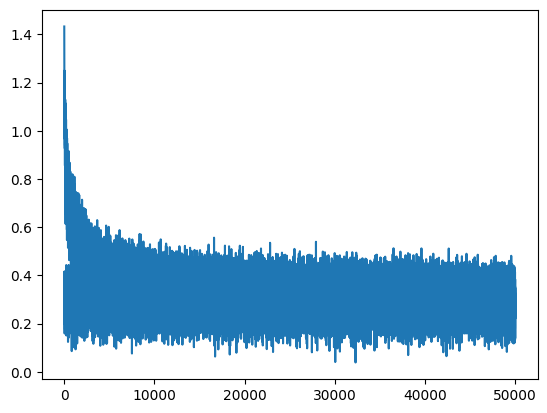

In [202]:
plt.plot(stepi, lossi)

In [203]:
emb = C[Xdev] # (33, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (33, 100) hidden layer
logits = h @ W2 + b2 # (33, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1799, grad_fn=<NllLossBackward0>)

In [204]:
emb = C[Xtr] # (33, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (33, 100) hidden layer
logits = h @ W2 + b2 # (33, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9335, grad_fn=<NllLossBackward0>)

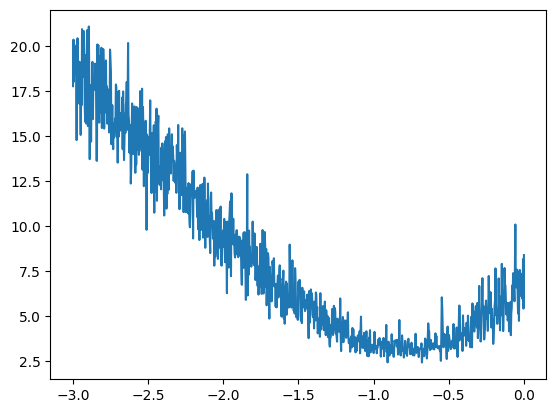

In [98]:
plt.plot(lri, lossi)

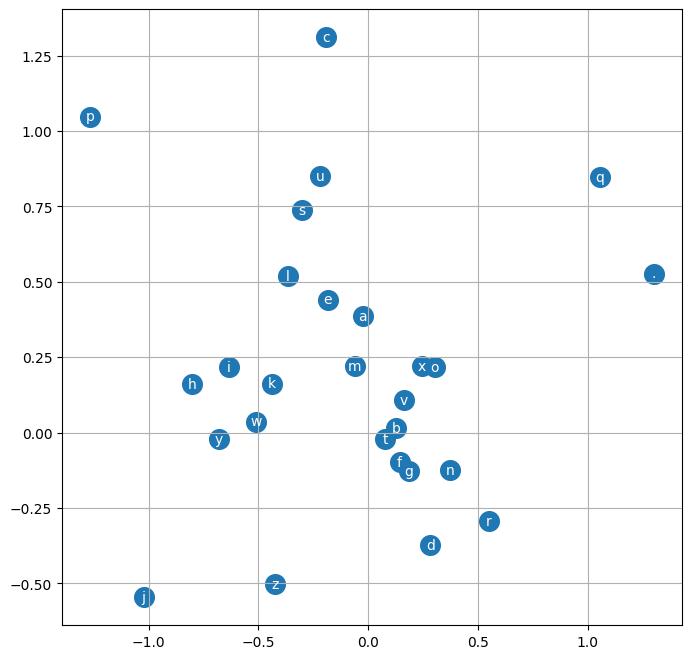

In [205]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [206]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size # init with all ...
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

mohajamyan.
shel.
nahri.
mareshwaj.
jaram.
radeep.
seli.
hemlajen.
akependra.
artesh.
koshara.
noshub.
rgihiriya.
kini.
saki.
punkeshwaushpalder.
yarafmehs.
kar.
muskkada.
har.


In [ ]:
# ----------- REFACTORED END-TO-END ---------------

In [207]:
f = [name.rstrip() for name in open('names.txt').readlines()]
words = []
for w in f:
  if w.isalpha():
    words.append(w)
chars = sorted(set(''.join(words)))
print(words[:5])
print(len(words))

['aabid', 'aabida', 'aachal', 'aadesh', 'aadil']
6467


In [208]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [209]:
block_size = 3 # context length: how many char do we take to predict the nxt one?
# build the dataset
def build_dataset(words):
  X, Y = [], []
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([38046, 3]) torch.Size([38046])
torch.Size([4741, 3]) torch.Size([4741])
torch.Size([4778, 3]) torch.Size([4778])


In [210]:
# MLP revisited
n_embed = 10 # the dimensionality of char embedding vectors
n_hidden = 200 # num of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

params = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in params)) # total num of params to the neural net
for p in params:
  p.requires_grad = True

11897


In [211]:
# optimization revisited
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embed the chars into vectors
  embcat = emb.view(emb.shape[0], -1) # concat the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activations
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update weights
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay after some steps of training
  for p in params:
    p.data += -lr * p.grad

  # tracking stats
  if i % 10000 == 0: # print every 10k steps
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 24.0623
  10000/ 200000: 2.1693
  20000/ 200000: 1.7975
  30000/ 200000: 2.1246
  40000/ 200000: 2.3500
  50000/ 200000: 1.8434
  60000/ 200000: 2.3787
  70000/ 200000: 2.3181
  80000/ 200000: 1.9837
  90000/ 200000: 1.7446
 100000/ 200000: 2.1961
 110000/ 200000: 2.1446
 120000/ 200000: 1.5920
 130000/ 200000: 1.6673
 140000/ 200000: 1.6666
 150000/ 200000: 1.8806
 160000/ 200000: 1.9791
 170000/ 200000: 2.0537
 180000/ 200000: 2.1376
 190000/ 200000: 1.8737


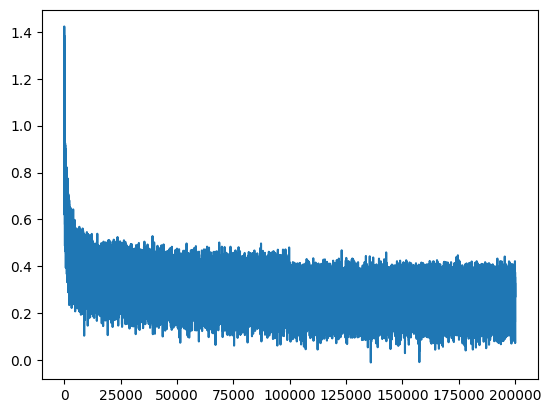

In [212]:
plt.plot(lossi)

In [213]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
split_loss('train')
split_loss('val')

train 1.8496228456497192
val 2.182541847229004


In [215]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # init with all ...
  while True:
    # forward pass the neural net
    emb = C[torch.tensor([context])] # (1, block_size, n_embed)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the prob distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token then break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)) # decode and print the generated word

mohabir.
anusreem.
dhrampateshwar.
jgrimza.
deep.
seli.
jewa.
pender.
parsumaan.
kaluckhyaramn.
shuber.
shimansi.
jairajeet.
jabaudanu.
meghetraj.
jul.
mho.
kar.
mustkish.
hir.
